In [0]:
from datetime import datetime
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import mnist as dataset
import tensorflow as tf

% matplotlib inline

# VGG Model

학습 할 모델을 설계 해줍니다. 아래는 [VGG](https://arxiv.org/abs/1409.1556) [1] 모델을 예시로 하였습니다. 

**reference**  
[1] Karen Simonyan, Andrew Zisserman. "[Very Deep Convolutional Networks for Large-Scale Image Recognition](https://arxiv.org/abs/1409.1556)". *arxiv:1409.1556*, 2014.

In [0]:
class Model:
    def __init__(self, num_class, is_training):
        self.num_class = num_class
        self.is_training = is_training
        self.drop_rate = 0.7 if is_training else 1.0

    def conv_block(self, inputs, filters=64, kernel_size=(3, 3), strides=(1, 1), name='conv'):
        conv = tf.keras.layers.Conv2D(filters=filters,
                                      kernel_size=kernel_size,
                                      strides=strides,
                                      padding='SAME',
                                      name=name)(inputs)
        norm = tf.keras.layers.BatchNormalization()(conv)
        acts = tf.keras.layers.ReLU()(norm)
        return acts

    def max_pooling(self, inputs, name='pool'):
        return tf.keras.layers.MaxPool2D(name=name)(inputs)

    def inference(self, input_shape):
        with tf.variable_scope("conv_layer"):
            inputs = tf.keras.layers.Input(input_shape)
            net = self.conv_block(inputs, filters=64, name='conv_1_1')
            net = self.conv_block(net, filters=64, name='conv_1_2')
            net = self.max_pooling(net, name='pool_1')

            net = self.conv_block(net, filters=128, name='conv_2_1')
            net = self.conv_block(net, filters=128, name='conv_2_2')
            net = self.max_pooling(net, name='pool_2')

            net = self.conv_block(net, filters=256, name='conv_3_1')
            net = self.conv_block(net, filters=256, name='conv_3_2')
            net = self.conv_block(net, filters=256, name='conv_3_3')
            net = self.max_pooling(net, name='pool_3')

            net = self.conv_block(net, filters=512, name='conv_4_1')
            net = self.conv_block(net, filters=512, name='conv_4_2')
            net = self.conv_block(net, filters=512, name='conv_4_3')
            net = self.max_pooling(net, name='pool_4')
            
#             net = self.conv_block(net, filters=512, name='conv_5_1')
#             net = self.conv_block(net, filters=512, name='conv_5_2')
#             net = self.conv_block(net, filters=512, name='conv_5_3')
#             net = self.max_pooling(net, name='pool_5')
            
        with tf.variable_scope("FC_layer"):
            net = tf.keras.layers.Flatten()(net)
            net = tf.keras.layers.Dense(4096, activation='relu')(net)
            net = tf.keras.layers.Dropout(self.drop_rate)(net)
            net = tf.keras.layers.Dense(4096, activation='relu')(net)
            net = tf.keras.layers.Dropout(self.drop_rate)(net)
            net = tf.keras.layers.Dense(self.num_class)(net)
        return tf.keras.Model(inputs=inputs, outputs=net)

# Util

In [0]:
def onehot_encoding(labels, num_class=10):
    onehot = np.zeros((num_class))
    onehot[labels] = 1
    return onehot

def load_data(batch_data):
    batch_images = []
    batch_labels = []
    for x, y in batch_data:
        
        images = np.expand_dims(x, -1)
        labels = onehot_encoding(y, num_class)
        
        batch_images.append(images)
        batch_labels.append(labels)
    
    return np.asarray(batch_images).astype(np.float32), np.asarray(batch_labels).astype(np.float32)

# Set HyperParameter

In [0]:
#@title Set Hyperparameter { display-mode: "form", run: "auto" }

num_class = 10
is_training = True

learning_rate = 0.001  #@param [0.01, 0.001, 0.0001]
batch_size = 64  #@param [32, 64, 128]
num_epochs = 5  #@param {type:"slider", min:1, max:100, step:1}



# Set Optimization

In [0]:
# Load DataSet
(train_images, train_labels), (test_images, test_labels) = dataset.load_data()
train_data = [(x, y) for x, y in zip(train_images, train_labels)]
test_data = [(x, y) for x, y in zip(test_images, test_labels)]

In [0]:
# Build Optimization for Model VGG
image = tf.placeholder(tf.float32, shape=(None, 28, 28, 1), name='image')
label = tf.placeholder(tf.float32, shape=(None, 10), name='label')

vgg = Model(num_class, is_training)

pred = vgg.inference(image.shape[1:])(image)
cost = tf.losses.softmax_cross_entropy(onehot_labels=label, logits=pred)
optm = tf.train.AdamOptimizer(learning_rate).minimize(cost)

accr, accr_op = tf.metrics.accuracy(labels=tf.argmax(label, axis=-1), predictions=tf.argmax(pred, axis=-1))

saver = tf.train.Saver()
save_path = "tmp/model.ckpt"
save_dir = os.path.dirname(save_path)
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

init_op = [tf.global_variables_initializer(), tf.local_variables_initializer()]

# Start Training

In [0]:
# Start Training from below codes
with tf.Session() as sess:
    sess.run(init_op)
    
    global_step = 0
    num_batches = len(train_data) // batch_size
    
    for epoch_n in range(num_epochs):
        cost_total = 0
        accr_total = 0
        
        for step in range(num_batches):
            batch_data = train_data[batch_size * step: batch_size * (step + 1)]
            batch_images, batch_labels = load_data(batch_data)
            
            feed_dict = {image: batch_images, label: batch_labels}
            
            _, cost_val, accr_val = sess.run([optm, cost, accr_op], feed_dict=feed_dict)
            cost_total += cost_val
            accr_total += accr_val
            
            global_step += 1
        
        saver.save(sess, save_path, global_step=global_step)
        print('[%d/%d] Cost: %.4f, Accuracy: %.4f' % (epoch_n, num_epochs, cost_total/(step+1), accr_total/(step+1)))

INFO:tensorflow:Restoring parameters from tmp/model.ckpt-2811
Saved Checkpoint are Loaded Successfully!
Accuracy for Test is 1.0000


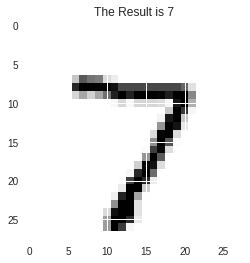

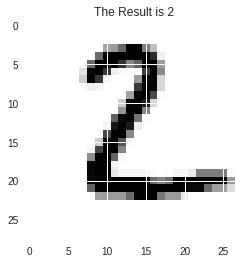

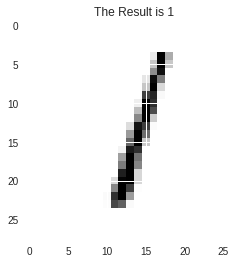

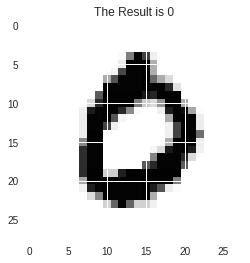

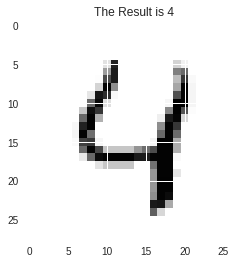

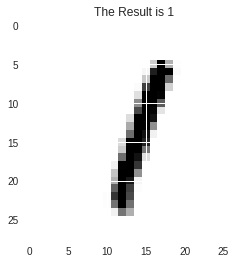

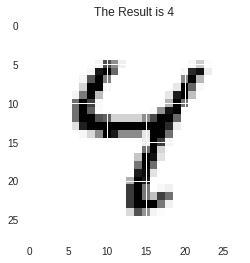

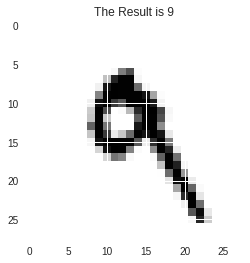

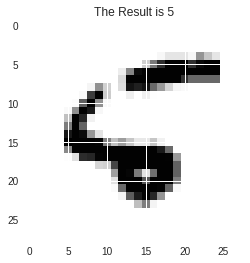

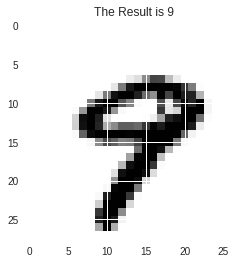

In [43]:
# Evaluate Model
with tf.Session() as sess:
    ckpt_status = tf.train.get_checkpoint_state(save_path)  # 마지막으로 저장한 Checkpoint 확인하기 
    latest_ckpt = ckpt_status.model_checkpoint_path  # 마지막 Checkpoint 불러오기
    saver.restore(sess, latest_ckpt)  # 마지막 Checkpoint Restore 하기
    print("Saved Checkpoint are Loaded Successfully!")
    
    batch_data = test_data[:10]  # 데이터 앞에 10개만 불러오기
    batch_images, batch_labels = load_data(batch_data)  # 모델에 들어갈 수 있도록 정제

    feed_dict = {image: batch_images, label: batch_labels}
    logits = sess.run(pred, feed_dict=feed_dict)
    result = np.argmax(logits, -1)
    
    test_accuracy = np.mean(result == np.argmax(batch_labels, -1))
    print("Accuracy for Test is %.4f" % test_accuracy)
    
    for i in range(batch_images.shape[0]):
        plt.title("The Result is %d" % result[i])
        plt.imshow(np.squeeze(batch_images[i]))
        plt.show()